In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
import numpy as np
import datasets
import pandas as pd
import random
#import umap
import sys
import evaluate
import json
import seaborn as sns
import re
import nltk
import sqlite3
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict, concatenate_datasets
from torch import nn
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Transformer, Pooling
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from IPython.core.debugger import Pdb, set_trace
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import util
#from tqdm.notebook import tqdm
from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from pprint import pprint
from scipy.cluster.hierarchy import linkage

from nbtools.utils import files, strings
from nbtools.sent_encoders import from_hf

datasets.disable_caching()

cache_dir = '/data/john/cache'
proot = files.project_root()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
# read the main dataset
#ds = Dataset.from_json('/data/john/projects/llm_eval/data/results/20240502-185939/all_scores.json')
#print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 961792
})


In [73]:
#print(ds)

ex = list(zip(*[ds[key][:5] for key in keys]))
print(ex)
#print(list(zip(ds[keys[0]][:5], ds[keys[1]][:5])))

[(0, 'icl', 'all_sides', "you are to read several documents and briefly provide information according to the user's needs", "Document 1:\nIn a renewed push to clamp down on the influx of illegal crossings along the southern U.S. border, the Trump administration is reportedly weighing a policy that would separate parents from their children in detention centers. The measure could also penalize migrants who live in the U.S. illegally and try to bring their children into the country, The Washington Post first reported Thursday. Families apprehended at the border have historically been detained together. This new policy, according to The New York Times, would place parents in adult detention centers and children either in separate shelters or in the care of 'sponsors.' The new Department of Homeland Security secretary Kirstjen Nielsen hasn't yet given her official approval, the Times reported. But the White House is on board, and Immigration and Customs Enforcement has approved the policy.

In [2]:
# Convert all_scores_fixed.json to a db file
ds = Dataset.from_json(
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'all_scores_fixed.json'
)

db_path = '/data/john/projects/llm_eval/data/results/20240502-185939/data.db'
if files.path_exists(db_path):
    raise Exception('dabatase exists')

con = sqlite3.connect(db_path)
keys = list(ds.features.keys())
print(len(keys))
cur = con.cursor()
cur.execute(
    """
    CREATE TABLE IF NOT EXISTS scores(
        id INT,
        template TEXT,
        dataset TEXT,
        system INT,
        prompt TEXT,
        response TEXT,
        el_index INT,
        semf1_use DOUBLE,
        semf1_distil DOUBLE,
        semf1_rob DOUBLE,
        bertscore DOUBLE,
        hashcode TEXT,
        model TEXT,
        sys_text_id INT,
        prompt_text_id INT,
        rougeLsum DOUBLE,
        rougeL DOUBLE,
        rouge1 DOUBLE,
        rouge2 DOUBLE,
        PRIMARY KEY (el_index, id, dataset, model, template, sys_text_id, prompt_text_id)
    )
    """
)
cur.executemany(
    "INSERT INTO scores VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    zip(*[ds[key] for key in keys])
)
con.commit()


Exception: dabatase exists

In [3]:
# connect to db
db_path = '/data/john/projects/llm_eval/data/results/20240502-185939/data.db'
con = sqlite3.connect(db_path)
cur = con.cursor()

keys = [
    'id', 'template', 'dataset', 'system', 'prompt', 'response',
    'el_index', 'semf1_use', 'semf1_distil', 'semf1_rob', 'bertscore',
    'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum',
    'rougeL', 'rouge1', 'rouge2',
]

In [4]:
ds = Dataset.from_json(
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'all_scores_fixed.json'
)
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2'],
    num_rows: 961792
})


In [5]:
ref_data = {
    'all_sides': Dataset.from_json('/data/john/projects/llm_eval/data/all_sides/test.json'),
    'privacy_policy': Dataset.from_csv('/data/john/projects/llm_eval/data/privacy_policy/3p_data.csv')
}
doc_cols = {
    'all_sides': ['Left', 'Right'],
    'privacy_policy': ['Company_1', 'Company_2'],
}
ref_cols = {
    'all_sides': [
        'Ahmed_Intersection', 
        'Naman_Intersection', 
        'Helen_Intersection', 
        'AllSides_Intersection'],
    'privacy_policy': [
        'Annotator1', 
        'Annotator2', 
        'Annotator3'],
}
print(ref_data)

{'all_sides': Dataset({
    features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
    num_rows: 137
}), 'privacy_policy': Dataset({
    features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
    num_rows: 135
})}


In [6]:
fname = (
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'annotation_samples_complete.xlsx'
)
human_scores = Dataset.from_pandas(pd.read_excel(fname))
print(human_scores)

# connect to db
db_path = '/data/john/projects/llm_eval/data/results/20240502-185939/data.db'
cur = con.cursor()

ann_keys = [
    'Column1', 'doc1', 'doc2', 'response', 'id', 'template', 
    'dataset', 'system', 'prompt', 'index', 'semf1_use', 'semf1_distil', 
    'semf1_rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 
    'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 
    'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'
]

tables = [
    el[0] for el in 
    cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
]
if 'annotations' in tables:
    raise Exception('table already created')

res = cur.execute(
    """
    CREATE TABLE IF NOT EXISTS annotations(
        Column1 INTEGER,
        doc1 TEXT,
        doc2 TEXT,
        response TEXT,
        id INTEGER,
        template TEXT,
        dataset TEXT,
        system TEXT,
        prompt TEXT,
        el_index INTEGER,
        semf1_use DOUBLE,
        semf1_distil DOUBLE,
        semf1_rob DOUBLE,
        bertscore DOUBLE,
        hashcode TEXT,
        model TEXT,
        sys_text_id INTEGER,
        prompt_text_id INTEGER,
        rougeLsum DOUBLE,
        rougeL DOUBLE,
        rouge1 DOUBLE,
        rouge2 DOUBLE,
        annotator_1 DOUBLE,
        annotator_2 DOUBLE,
        annotator_3 DOUBLE,
        annotator_agreement DOUBLE,
        FOREIGN KEY (el_index, id, dataset, model, template, sys_text_id, prompt_text_id) REFERENCES scores
    )
    """
)

cur.executemany(
    "INSERT INTO annotations VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    zip(*[human_scores[key] for key in ann_keys])
)
con.commit()
cur.close()

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 630
})


Exception: table already created

In [5]:
os.chdir('/data/john/projects/llm_eval/data/results/20240502-185939-rouge')
os.listdir()

FileNotFoundError: [Errno 2] No such file or directory: '/data/john/projects/llm_eval/data/results/20240502-185939-rouge'

In [8]:
# get file names in target path
base_path = './'
targets = []
for path, subdirs, fnames in os.walk(base_path):
    for name in fnames:
        if name.endswith('scores.json'):
            targets.append(os.path.join(path, name))
targets = sorted(targets)
target_groups = list(zip(
    [targets[i] for i in range(0, len(targets), 2)],
    [targets[i] for i in range(1, len(targets), 2)]
))
pprint(target_groups)

[('./gemini-pro/all_sides-scores.json',
  './gemini-pro/privacy_policy-scores.json'),
 ('./gpt-3.5-turbo/all_sides-scores.json',
  './gpt-3.5-turbo/privacy_policy-scores.json'),
 ('./lmsys/vicuna-13b-v1.5-16k/all_sides-scores.json',
  './lmsys/vicuna-13b-v1.5-16k/privacy_policy-scores.json'),
 ('./lmsys/vicuna-13b-v1.5/all_sides-scores.json',
  './lmsys/vicuna-13b-v1.5/privacy_policy-scores.json'),
 ('./lmsys/vicuna-7b-v1.5-16k/all_sides-scores.json',
  './lmsys/vicuna-7b-v1.5-16k/privacy_policy-scores.json'),
 ('./lmsys/vicuna-7b-v1.5/all_sides-scores.json',
  './lmsys/vicuna-7b-v1.5/privacy_policy-scores.json'),
 ('./meta-llama/Llama-2-13b-chat-hf/all_sides-scores.json',
  './meta-llama/Llama-2-13b-chat-hf/privacy_policy-scores.json'),
 ('./meta-llama/Llama-2-7b-chat-hf/all_sides-scores.json',
  './meta-llama/Llama-2-7b-chat-hf/privacy_policy-scores.json'),
 ('./meta-llama/Meta-Llama-3-8B-Instruct/all_sides-scores.json',
  './meta-llama/Meta-Llama-3-8B-Instruct/privacy_policy-scores.

In [10]:
model_names = [re.match(r'\./(.*)/.*', trgt).groups()[0] for trgt in targets]
model_names = [model_names[i] for i in range(0, len(model_names), 2)]
print(model_names)

['gemini-pro', 'gpt-3.5-turbo', 'lmsys/vicuna-13b-v1.5-16k', 'lmsys/vicuna-13b-v1.5', 'lmsys/vicuna-7b-v1.5-16k', 'lmsys/vicuna-7b-v1.5', 'meta-llama/Llama-2-13b-chat-hf', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Meta-Llama-3-8B-Instruct', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3-mini-4k-instruct', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.2', 'mosaicml/mpt-30b-chat', 'mosaicml/mpt-30b-instruct', 'mosaicml/mpt-7b-chat', 'mosaicml/mpt-7b-instruct']


In [30]:
dsets = []
for as_path, pp_path in target_groups:

    # check if model names are the same
    m_name1 = re.match(r'\./(.*)/.*', as_path).groups()[0]
    m_name2 = re.match(r'\./(.*)/.*', pp_path).groups()[0]
    assert m_name1 == m_name2

    # set model name
    model_name = m_name1

    res_path = as_path.replace('all_sides-scores', 'results')
    print(res_path)

    # read in datasets
    res_data = Dataset.from_json(res_path)
    as_data = Dataset.from_json(as_path)
    pp_data = Dataset.from_json(pp_path)

    # get originally ignored samples
    ig_data = res_data.filter(
        lambda x: x['response'] == None or x['response'].strip() == ''
    )

    # add missing columns
    cols = set(as_data.features.keys()) - set(ig_data.features.keys())
    cols.remove('index')

    for col in cols:
        ig_data = ig_data.add_column(col, [0.0]*len(ig_data))

    model_data = concatenate_datasets([
        as_data, pp_data, ig_data,
    ])
    model_data = model_data.add_column('model', [model_name]*len(model_data))
    dsets.append(model_data)
rouge_data = concatenate_datasets(dsets)
print(rouge_data)

./gemini-pro/results.json


Filter:   0%|          | 0/56576 [00:00<?, ? examples/s]

Filter: 100%|██████████| 56576/56576 [00:00<00:00, 172476.36 examples/s]


./gpt-3.5-turbo/results.json


Flattening the indices: 100%|██████████| 3/3 [00:00<00:00, 1398.41 examples/s]


./lmsys/vicuna-13b-v1.5-16k/results.json


Flattening the indices: 100%|██████████| 23/23 [00:00<00:00, 8731.02 examples/s]


./lmsys/vicuna-13b-v1.5/results.json


Flattening the indices: 100%|██████████| 20/20 [00:00<00:00, 7556.62 examples/s]


./lmsys/vicuna-7b-v1.5-16k/results.json


Flattening the indices: 100%|██████████| 43/43 [00:00<00:00, 14751.76 examples/s]


./lmsys/vicuna-7b-v1.5/results.json


Flattening the indices: 100%|██████████| 19/19 [00:00<00:00, 7453.40 examples/s]


./meta-llama/Llama-2-13b-chat-hf/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 170060.47 examples/s]


./meta-llama/Llama-2-7b-chat-hf/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 170383.93 examples/s]


./meta-llama/Meta-Llama-3-8B-Instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 151499.66 examples/s]


./microsoft/Phi-3-mini-128k-instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 177424.51 examples/s]


./microsoft/Phi-3-mini-4k-instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 173064.30 examples/s]


./mistralai/Mistral-7B-Instruct-v0.1/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 175730.47 examples/s]


./mistralai/Mistral-7B-Instruct-v0.2/results.json


Flattening the indices: 100%|██████████| 26/26 [00:00<00:00, 11160.77 examples/s]


./mosaicml/mpt-30b-chat/results.json


Flattening the indices: 100%|██████████| 300/300 [00:00<00:00, 31342.10 examples/s]


./mosaicml/mpt-30b-instruct/results.json


Flattening the indices: 100%|██████████| 299/299 [00:00<00:00, 30623.58 examples/s]


./mosaicml/mpt-7b-chat/results.json


Flattening the indices: 100%|██████████| 359/359 [00:00<00:00, 34698.02 examples/s]


./mosaicml/mpt-7b-instruct/results.json


Flattening the indices: 100%|██████████| 292/292 [00:00<00:00, 32324.34 examples/s]


Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'model'],
    num_rows: 961792
})


In [32]:
for i, (s1, s2) in tqdm(enumerate(zip(rouge_data, ds)), total=len(rouge_data)):


    idres = s1["id"] == s2["id"]
    dsres = s1["dataset"] == s2["dataset"]
    mres = s1["model"] == s2["model"]
    pres = s1["prompt"] == s2["prompt"]
    if not all([idres, dsres, mres]):
        print(i)
print(i)

  0%|          | 0/961792 [00:00<?, ?it/s]

100%|██████████| 961792/961792 [02:26<00:00, 6559.06it/s]

961791


In [40]:
cols = set(ds.features.keys())
rouge_cols = {col for col in cols if 'rouge' in col}

fixed_data = ds.remove_columns(rouge_cols)
for col in rouge_cols:
    fixed_data = fixed_data.add_column(col, rouge_data[col])

0.26028275207559626


In [3]:
fixed_data.to_json('/data/john/projects/llm_eval/data/results/20240502-185939/all_scores_fixed.json')

NameError: name 'fixed_data' is not defined

In [44]:
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2'],
    num_rows: 961792
})


In [51]:
ds = Dataset.from_json(
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'all_scores_fixed.json'
)
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2'
]
model_names = set(ds['model'])
ref_data = set(ds['dataset'])
templates = set(ds['template'])

best_prompts = {ds_name: {} for ds_name in ref_data}
#best_prompts[ds_name] = {}
for ds_name, tmplt in tqdm(
        product(ref_data, templates),
        total=len(ref_data)*len(templates)):

    ref_ds = ds.filter(
        lambda x: x['dataset'] == ds_name and x['template'] == tmplt
    )
    sys_ids = set(ref_ds['sys_text_id'])
    prompt_ids = set(ref_ds['prompt_text_id'])
    candidates = []
    mean_scores = []
    for sid, pid in product(sys_ids, prompt_ids):
        tmplt_ds = ref_ds.filter(
            lambda x: x['sys_text_id'] == sid 
                and x['prompt_text_id'] == pid
        )
        candidates.append((sid, pid))
        mean = np.mean([np.mean(tmplt_ds[met]) for met in metrics])
        mean_scores.append(mean)
    best = np.argmax(np.array(mean_scores))
    best_prompts[ds_name][tmplt] = dict(zip(
        ['sid', 'pid'], candidates[best]
    ))

print(best_prompts)


100%|██████████| 12/12 [32:19<00:00, 161.66s/it]

{'privacy_policy': {'l1': {'sid': 7, 'pid': 5}, 'l0': {'sid': 7, 'pid': 0}, 'l2': {'sid': 7, 'pid': 1}, 'l4': {'sid': 7, 'pid': 1}, 'l3': {'sid': 7, 'pid': 4}, 'icl': {'sid': 0, 'pid': 0}}, 'all_sides': {'l1': {'sid': 1, 'pid': 4}, 'l0': {'sid': 0, 'pid': 0}, 'l2': {'sid': 6, 'pid': 1}, 'l4': {'sid': 7, 'pid': 1}, 'l3': {'sid': 6, 'pid': 4}, 'icl': {'sid': 0, 'pid': 0}}}


In [35]:
pprint(best_prompts)

{'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}


In [3]:
best_prompts = {'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}

In [95]:
961792-56576

905216

In [104]:
len(ds.filter(lambda x: x['id'] == 1 and x['dataset'] == 'all_sides')

Filter:   0%|          | 0/961792 [00:00<?, ? examples/s]

Filter: 100%|██████████| 961792/961792 [00:17<00:00, 54818.44 examples/s]


3536

In [118]:
3536-(208*11)
208/6


34.666666666666664

# Build the Annotation Dataset

# Hardcode the Selected Samples

In [16]:
num_samples = 10
as_ids = set()
while len(as_ids) < num_samples:
    as_ids.add(random.randint(0, 136))

pp_ids = set()
while len(pp_ids) < num_samples:
    pp_ids.add(random.randint(0, 134))

sample_ids = {
    'all_sides': np.array(list(as_ids)),
    'privacy_policy': np.array(list(pp_ids)),
}
"""
sample_ids = {
    'all_sides': np.array([133,  16,  27,  92,  30]), 
    'privacy_policy': np.array([  3, 104, 111,  83,  53])
}
"""
sample_ids = {
    'all_sides': np.array([ 97,  98, 133,   7,   8,  44,  51,  21,  87,  90]), 
    'privacy_policy': np.array([  1, 134, 103, 113,  29,  20,  22, 122,  91, 125]),
}


print(sample_ids)


{'all_sides': array([ 97,  98, 133,   7,   8,  44,  51,  21,  87,  90]), 'privacy_policy': array([  1, 134, 103, 113,  29,  20,  22, 122,  91, 125])}


In [17]:
#models = sorted(set(ds['model']))
models = {
    'gemini-pro',
    'gpt-3.5-turbo',
    'lmsys/vicuna-13b-v1.5-16k',
    'meta-llama/Meta-Llama-3-8B-Instruct',
    'microsoft/Phi-3-mini-128k-instruct',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'mosaicml/mpt-30b-chat',
}
pprint(models)

{'gemini-pro',
 'gpt-3.5-turbo',
 'lmsys/vicuna-13b-v1.5-16k',
 'meta-llama/Meta-Llama-3-8B-Instruct',
 'microsoft/Phi-3-mini-128k-instruct',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'mosaicml/mpt-30b-chat'}


In [20]:
num_samples = 5

best_prompts = {'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}

#models = sorted(set(ds['model']))
selected_samples = []
for ds_name, cats in best_prompts.items():
    for tmplt, ids in cats.items():
        sid, pid = ids['sid'], ids['pid']
        for model in models:
            sample_ds = ds.filter(
                lambda x: x['sys_text_id'] == sid 
                    and x['prompt_text_id'] == pid
                    and x['dataset'] == ds_name
                    and x['model'] == model
                    and x['template'] == tmplt
                    and x['id'] in sample_ids[x['dataset']],
                num_proc=8
            )
            """
            print(sample_ds)
            print(sample_ds['id'])
            set_trace()
            sample_indices = []
            while len(sample_indices) < num_samples:
                idx = random.randint(0, len(sample_ds)-1)
                if idx not in sample_indices:
                    sample_indices.append(idx)
            sample_indices = np.array(sample_indices)
            """
            #selected_samples.append(sample_ds.select(sample_indices))
            selected_samples.append(sample_ds)

print(selected_samples)


Filter (num_proc=8): 100%|██████████| 961792/961792 [00:01<00:00, 567316.02 examples/s]


[Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore',

In [21]:
sampled_data = concatenate_datasets(selected_samples)

print(sampled_data)
print(len(set(sampled_data['index'])))
print(len(set(sampled_data['id'])))

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 840
})
120
20


### Read Reference Data

In [4]:
ref_data = {
    'all_sides': Dataset.from_json('/data/john/projects/llm_eval/data/all_sides/test.json'),
    'privacy_policy': Dataset.from_csv('/data/john/projects/llm_eval/data/privacy_policy/3p_data.csv')
}
doc_cols = {
    'all_sides': ['Left', 'Right'],
    'privacy_policy': ['Company_1', 'Company_2'],
}
ref_cols = {
    'all_sides': [
        'Ahmed_Intersection',
        'Naman_Intersection',
        'Helen_Intersection',
        'AllSides_Intersection'],
    'privacy_policy': [
        'Annotator1',
        'Annotator2',
        'Annotator3'],
}
print(ref_data)

{'all_sides': Dataset({
    features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
    num_rows: 137
}), 'privacy_policy': Dataset({
    features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
    num_rows: 135
})}


# Count Avg Tokens In Each Dataset

In [23]:
ds_names = ['all_sides', 'privacy_policy']
avg_overlap = {}
overlap = {
    'all_sides': [],
    'privacy_policy': [],
}
total_tokens = {
    'all_sides': [],
    'privacy_policy': [],
}
for name in ds_names:
    d1, d2 = doc_cols[name]
    for sample in ref_data[name]:
        t1 = set(word_tokenize(sample[d1]))
        t2 = set(word_tokenize(sample[d2]))
        total_tokens[name] += [len(t1), len(t2)]
        tokens = set(t1).intersection(set(t2))
        tokens = tokens - set(stopwords.words('english'))
        overlap[name].append(len(tokens))
for name in ds_names:
    avg_overlap[name] = np.mean(overlap[name])
print(avg_overlap)
print(np.mean(total_tokens['all_sides']))
print(np.mean(total_tokens['privacy_policy']))
print(
    f'3P: {avg_overlap["privacy_policy"]/np.mean(total_tokens["privacy_policy"])}\n'
    f'AS: {avg_overlap["all_sides"]/np.mean(total_tokens["all_sides"])}'
)

{'all_sides': 38.481751824817515, 'privacy_policy': 30.57037037037037}
164.72992700729927
170.3074074074074
3P: 0.17950111997912271
AS: 0.2336051045728465


# Add Source Documents to Selected Data

In [24]:
d1 = [ref_data[x['dataset']][x['id']][doc_cols[x['dataset']][0]] for x in sampled_data]
d2 = [ref_data[x['dataset']][x['id']][doc_cols[x['dataset']][1]] for x in sampled_data]

sampled_data = sampled_data.add_column('doc1', d1)
sampled_data = sampled_data.add_column('doc2', d2)
print(sampled_data)


Flattening the indices: 100%|██████████| 840/840 [00:00<00:00, 5040.37 examples/s]


Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'doc1', 'doc2'],
    num_rows: 840
})


In [19]:
#sampled_data = sampled_data.shuffle()
#sampled_data = sampled_data.rename_columns({'ref1': 'doc1', 'ref2': 'doc2'})
fprefix = '/data/john/projects/llm_eval/data/results/20240502-185939/sampled_data'
sampled_data.to_json(fprefix + '.json')
with pd.ExcelWriter(fprefix + '.xlsx') as writer:
    sampled_data.to_pandas().to_excel(writer)

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 22.50ba/s]

In [20]:
#sampled_data.select_columns([])
print(sampled_data.features.keys())
#sampled_data.select_columns(['index', 'doc1', 'doc2', 'response']).to_csv('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.csv')
fname = '/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.xlsx'

annotation_data = sampled_data.shuffle().select_columns(['index', 'doc1', 'doc2', 'response'])
with pd.ExcelWriter(fname) as writer:
    annotation_data.to_pandas().to_excel(writer)

dict_keys(['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'doc1', 'doc2'])


In [47]:
#annotation_data = Dataset.from_csv('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.csv')
annotation_data = Dataset.from_pandas(pd.read_excel('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples_alt.xlsx'))
print(annotation_data)

Dataset({
    features: ['Unnamed: 0', 'index', 'doc1', 'doc2', 'response'],
    num_rows: 420
})


# End Annotation Set Building

In [6]:
fname = (
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'annotation_samples_complete.xlsx'
)
human_scores = Dataset.from_pandas(pd.read_excel(fname))
print(human_scores)

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 630
})


In [5]:
print(human_scores[498]['Column1'])

787


# Create Agreement Matrix for Automatic Evaluation Scores and Annotator Scores

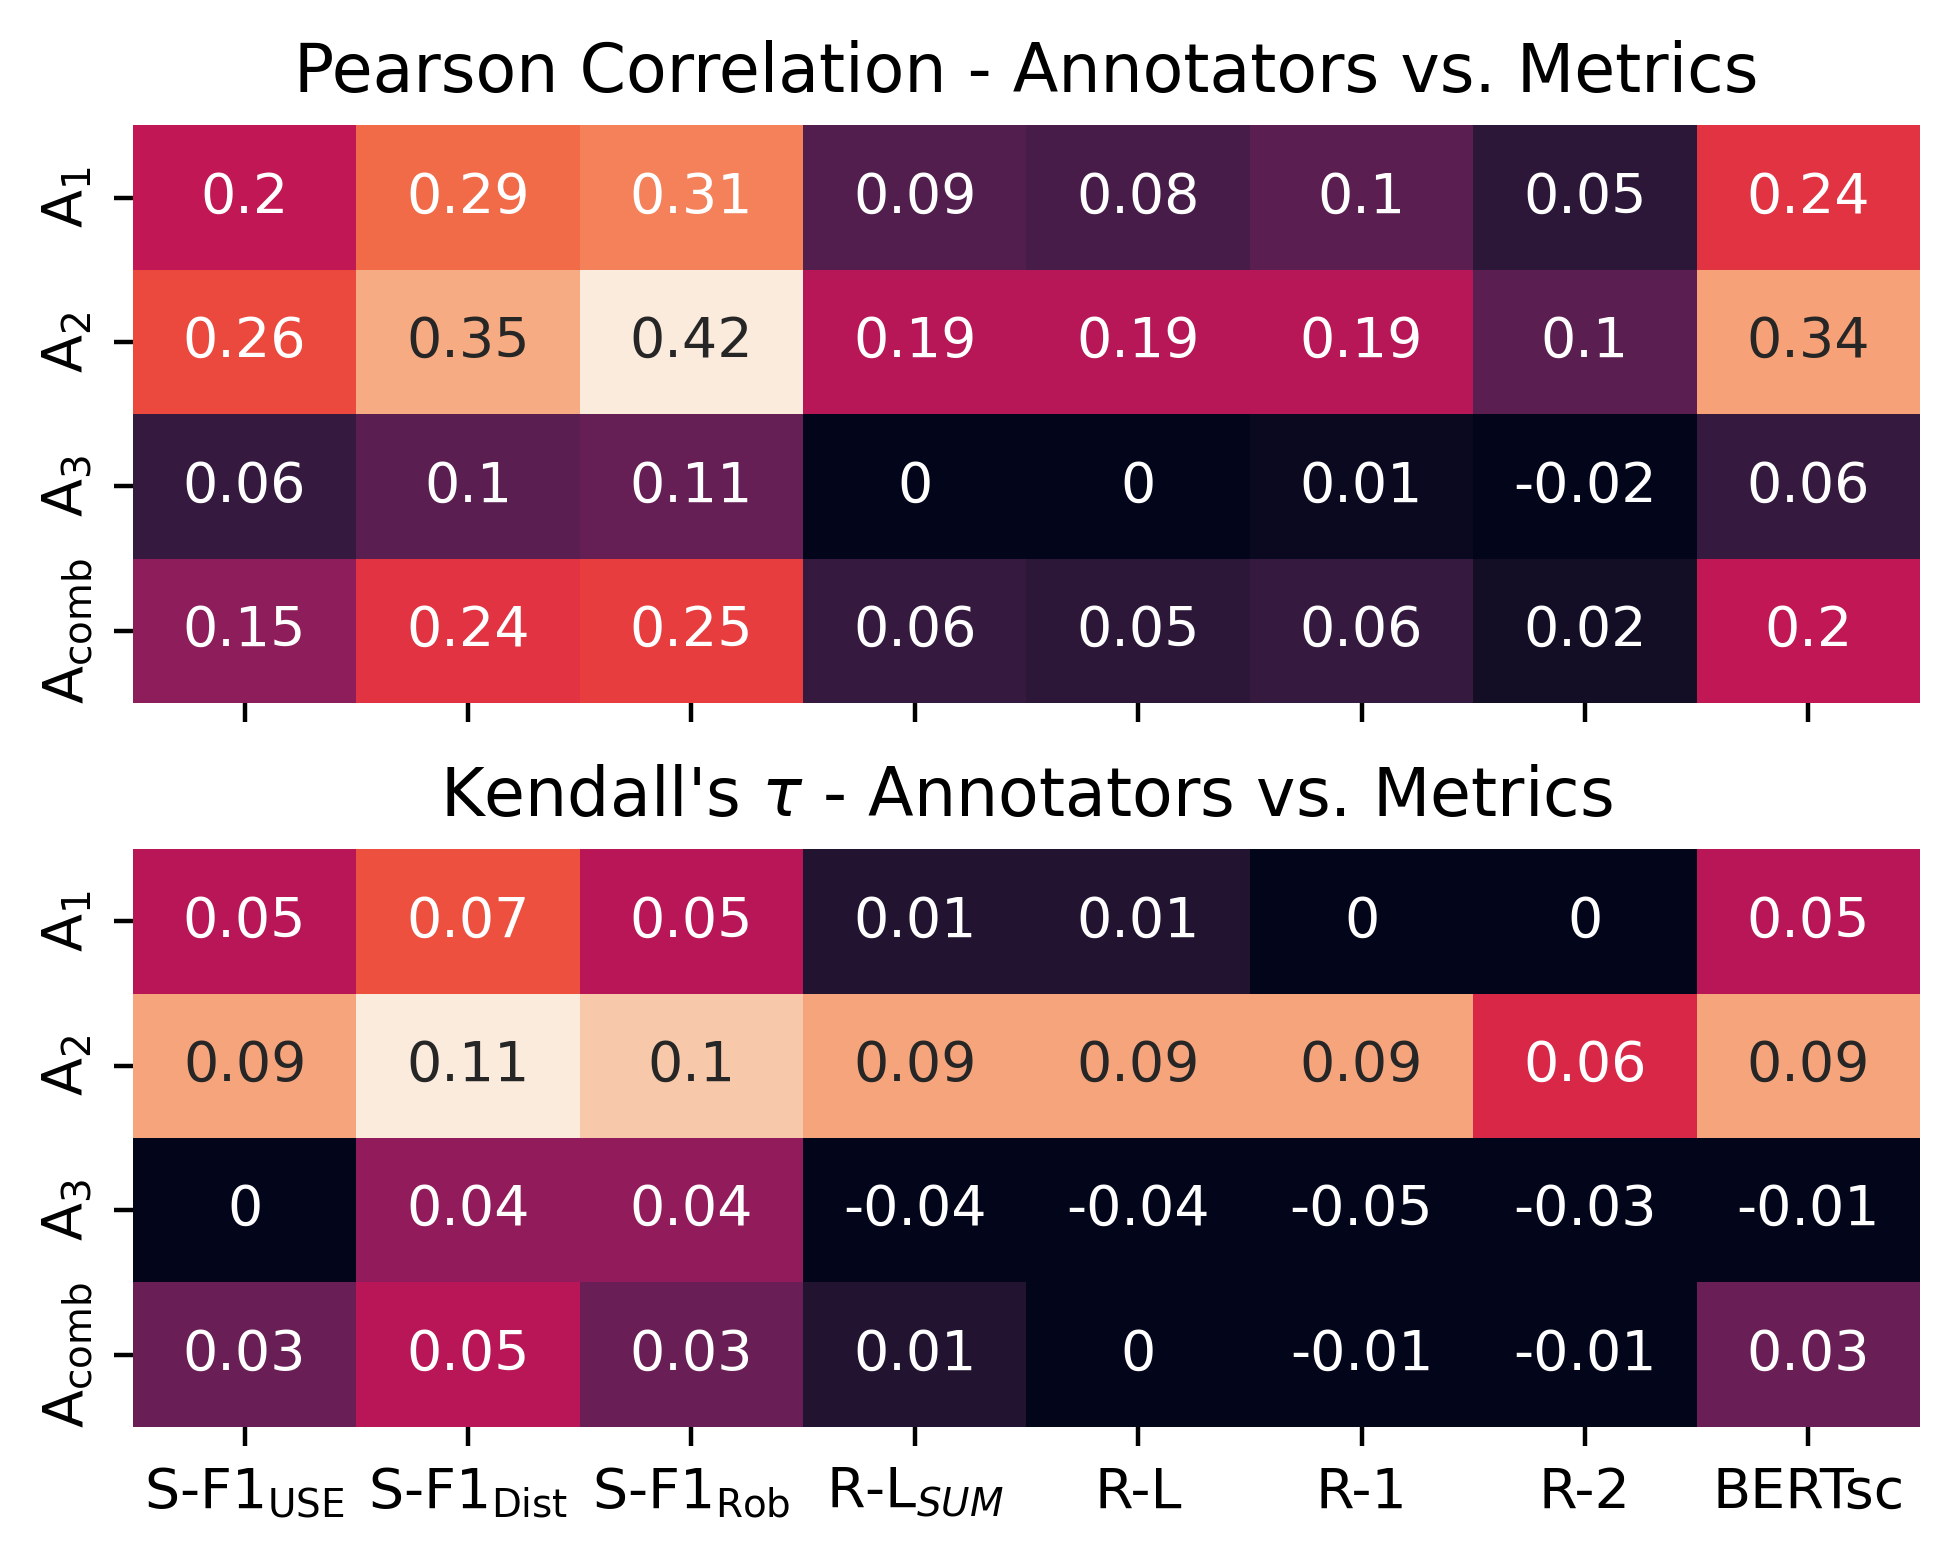

In [24]:
from scipy.stats import pearsonr, kendalltau

row = [
    'annotator_1', 'annotator_2', 'annotator_3',
    'annotator_agreement',
]

col = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
row_alias = [
    r'$\text{A}_1$', r'$\text{A}_2$', r'$\text{A}_3$',
    r'$\text{A}_{\text{comb}}$',
]
col_alias = [
    r'$\text{S-F1}_{\text{USE}}$', r'$\text{S-F1}_{\text{Dist}}$',
    r'$\text{S-F1}_{\text{Rob}}$',
    r'$\text{R-L}_{SUM}$',
    r'R-L', r'R-1', r'R-2',
    r'BERTsc'
]
pearson_agr = np.zeros((len(row), len(col)))
kendall_agr = np.zeros((len(row), len(col)))

for i, rname in enumerate(row):
    for j, cname in enumerate(col):

        # convert to numpy arrays and set empty cells to 0
        a = np.array(human_scores[rname], dtype=float)
        b = np.array(human_scores[cname], dtype=float)
        a[np.isnan(a)] = 0
        b[np.isnan(b)] = 0

        # ignore sample 498
        # TODO remove this
        a = np.delete(a, 498)
        b = np.delete(b, 498)

        pearson_agr[i, j] = pearsonr(a, b).statistic
        kendall_agr[i, j] = kendalltau(a, b).statistic

pearson_agr = np.round(pearson_agr, decimals=2)
pearson_agr[pearson_agr == -0] = 0

kendall_agr = np.round(kendall_agr, decimals=2)
kendall_agr[kendall_agr == -0] = 0

#print(pearson_agr)
fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    figsize=(5, 4), dpi=400,
    layout='tight',
)
sns.heatmap(
    pearson_agr, annot=True, vmin=0, cbar=False,
    xticklabels=col_alias, yticklabels=row_alias,
    ax=ax[0]
)
sns.heatmap(
    kendall_agr, annot=True, vmin=0, cbar=False,
    xticklabels=col_alias, yticklabels=row_alias,
    ax=ax[1]
)
ax[0].set_title('Pearson Correlation - Annotators vs. Metrics')
ax[1].set_title(r"Kendall's $\tau$ - Annotators vs. Metrics")
#ax[1].tick_params(axis='x', labelrotation=90)
#ax[0].tick_params(axis='y', labelrotation=0)
#ax[1].tick_params(axis='y', labelrotation=0)

plt.savefig('/data/john/files/fig/llm_eval/agreement.png')

In [29]:
h_scores = human_scores.select(
    np.delete(np.arange(len(human_scores)), 498)
)
models = set(h_scores['model'])
#model_pref_scores = np.zeros(len(models))
model_pref_scores = {}
for i, model in enumerate(models):
    model_data = h_scores.filter(lambda x: x['model'] == model)
    ann_scores = np.array(model_data['annotator_agreement'], dtype=float)
    ann_scores[np.isnan(ann_scores)] = 0
    avg_score = np.mean(ann_scores)

    model_pref_scores[model] = round(avg_score, 2)

#model_pref_scores = np.round(model_pref_scores, decimals=2)
#pprint(dict(zip(models, model_pref_scores)))
print(json.dumps(model_pref_scores, indent=4))

templates = list(set(h_scores['template']))
#template_pref_scores = np.zeros(len(templates))
template_pref_scores = {}
for i, tmplt in enumerate(templates):
    tmplt_data = h_scores.filter(lambda x: x['template'] == tmplt)
    ann_scores = np.array(tmplt_data['annotator_agreement'], dtype=float)
    ann_scores[np.isnan(ann_scores)] = 0
    avg_score = np.mean(ann_scores)

    template_pref_scores[tmplt] = round(avg_score, 2)

#template_pref_scores = np.round(template_pref_scores, decimals=2)
#print(templates)
print(json.dumps(template_pref_scores, indent=4))
#pprint(dict(zip(templates, template_pref_scores)))



Filter: 100%|██████████| 629/629 [00:00<00:00, 19730.59 examples/s]


{
    "gemini-pro": 3.37,
    "lmsys/vicuna-13b-v1.5-16k": 3.32,
    "mosaicml/mpt-30b-chat": 3.39,
    "microsoft/Phi-3-mini-128k-instruct": 3.37,
    "mistralai/Mistral-7B-Instruct-v0.2": 3.38,
    "gpt-3.5-turbo": 3.53,
    "meta-llama/Meta-Llama-3-8B-Instruct": 3.08
}


Filter: 100%|██████████| 629/629 [00:00<00:00, 19636.17 examples/s]

{
    "l0": 3.57,
    "l4": 3.32,
    "l2": 3.42,
    "l3": 3.32,
    "l1": 3.38,
    "icl": 3.08
}


In [30]:
as_count = human_scores['dataset'].count('all_sides')
ppp_count = human_scores['dataset'].count('privacy_policy')
print(as_count/42)
print(ppp_count/42)


7.0
8.0


In [123]:
sample = human_scores.filter(lambda x: x['id'] == 22 and x['model'] != 'meta-llama/Meta-Llama-3-8B-Instruct')
print(sample)

Filter: 100%|██████████| 630/630 [00:00<00:00, 34375.96 examples/s]

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 36
})


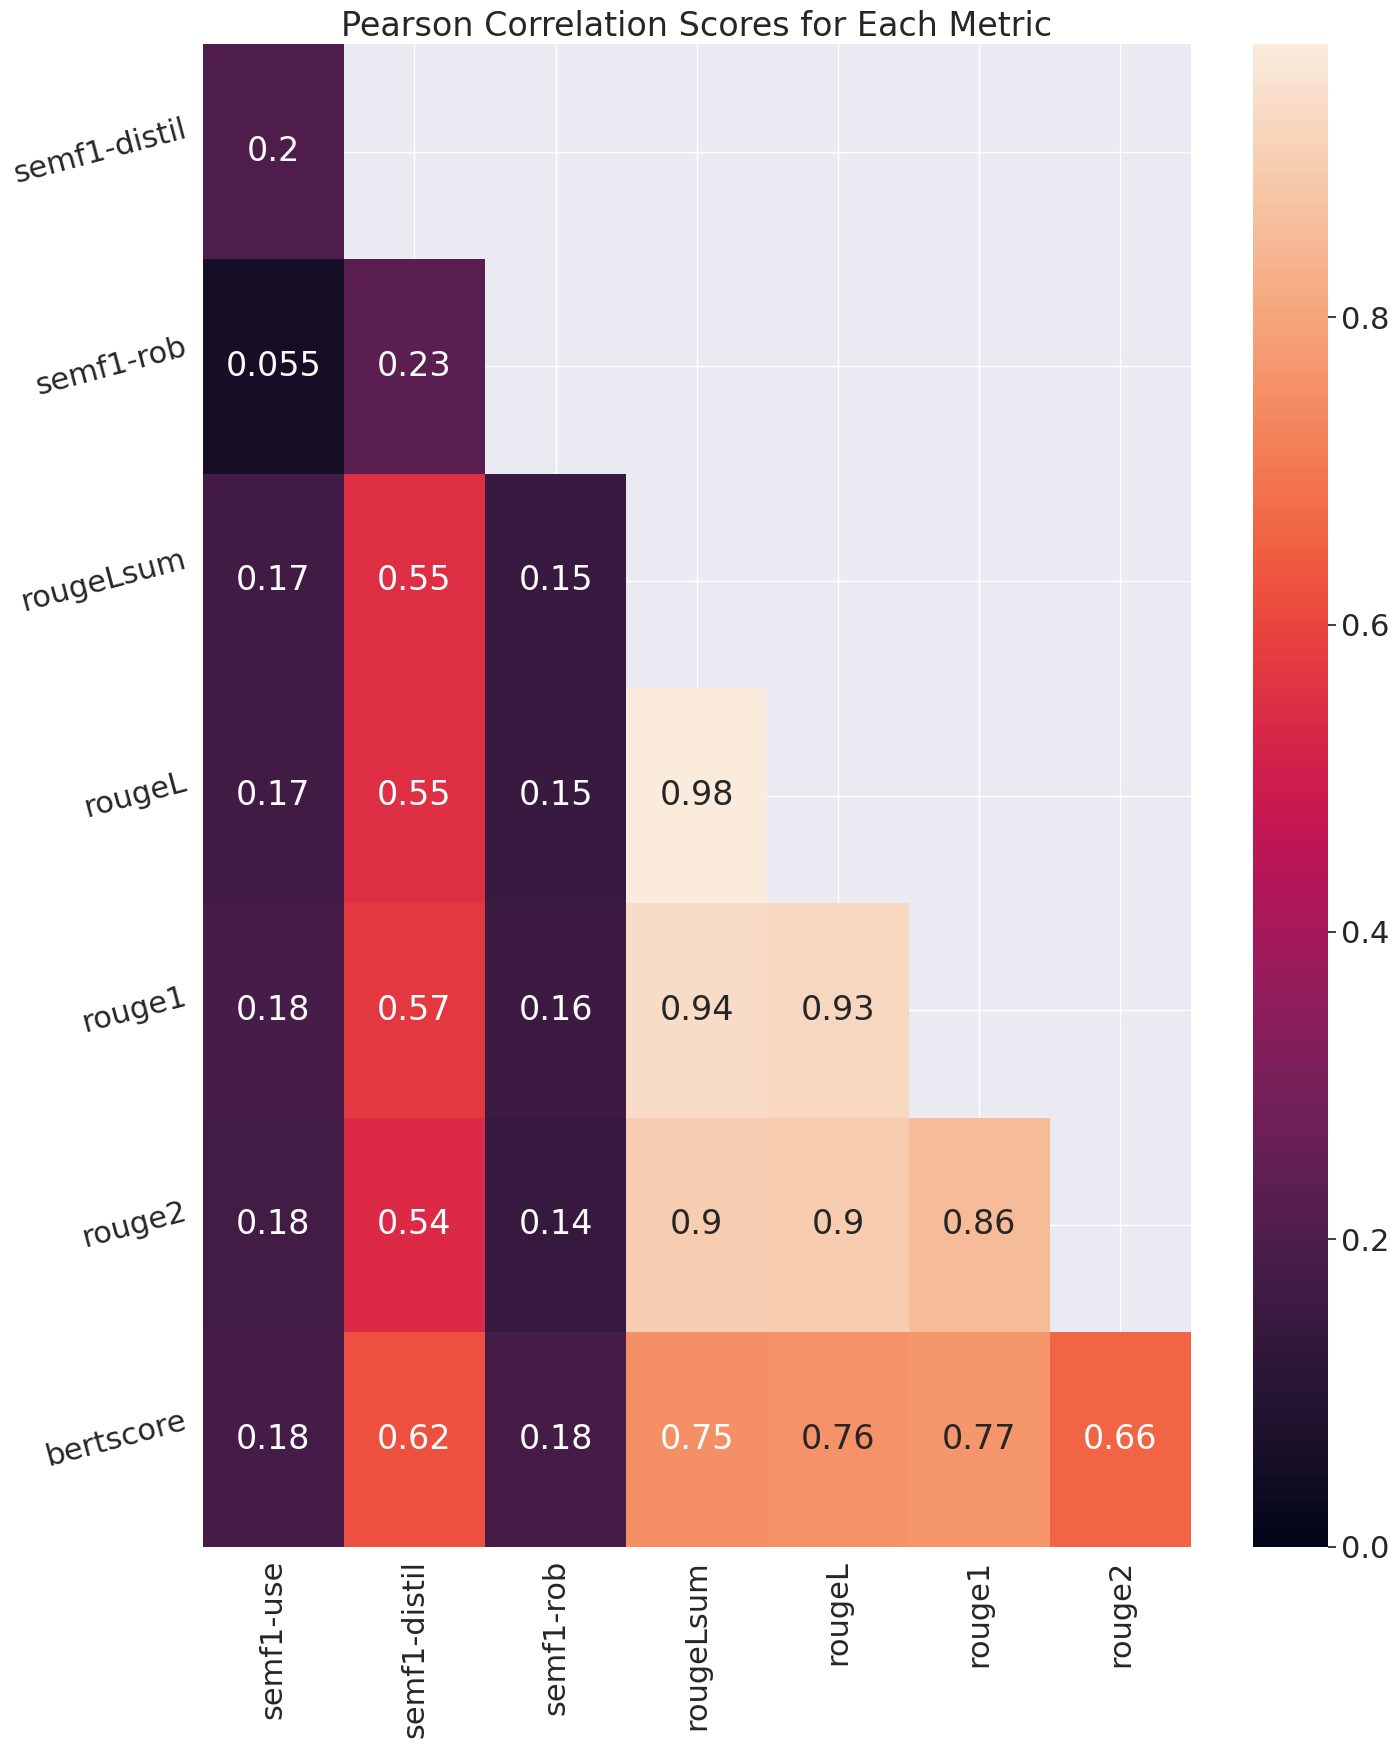

In [6]:
from scipy.stats import spearmanr, pearsonr, kendalltau

metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]

wh = 15.0, 18.0
sns.set_theme(rc={'figure.figsize': wh}, font_scale=2.0)
cor_mat = np.zeros((len(metrics), len(metrics)))

for i, m1 in enumerate(metrics):
    for j, m2 in enumerate(metrics):
        score = pearsonr(ds[m1], ds[m2]).statistic
        cor_mat[i, j] = score

fig, ax = plt.subplots()
sns.heatmap(
    cor_mat[1:, :-1],
    #cor_mat,
    annot=True,
    vmin=0,
    xticklabels=metrics[:-1],
    yticklabels=metrics[1:],
    #xticklabels=metrics,
    #yticklabels=metrics,
    mask=np.triu(np.ones(cor_mat[1:, :-1].shape, dtype=bool), k=1),
    #mask=np.triu(np.ones(cor_mat.shape, dtype=bool)),
)
plt.title(r"Pearson Correlation Scores for Each Metric")
#ax.tick_params(axis='x', labelrotation=15)
ax.tick_params(axis='y', labelrotation=15)
plt.gcf().subplots_adjust(
    bottom=0.15,
    left=0.15,
)
plt.tight_layout()

In [11]:
results = Dataset.from_list(results)
print(results)

NameError: name 'results' is not defined

In [24]:
from datasets.utils.logging import disable_progress_bar
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()

ds_names = ['all_sides', 'privacy_policy']
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
num_proc = 28
tmplt_ids = sorted(set(ds['template']))
models = sorted(set(ds['model']))
results = []
for name in tqdm(ds_names, position=0):
    print(f'on dataset {name}')
    data = ds.filter(
        lambda x: x['dataset'] == name,
        num_proc=num_proc
    )
    for tid in tqdm(tmplt_ids, position=1):
        print(f'*** on template {tid} ***')
        tdata = data.filter(
            lambda x: x['template'] == tid,
            num_proc=num_proc,
        )

        sys_ids = sorted(set(tdata['sys_text_id']))
        prmpt_ids = sorted(set(tdata['prompt_text_id']))
        for mod, sid, pid in tqdm(list(product(models, sys_ids, prmpt_ids)), position=2):
            print(f'on model: {mod}, sid: {sid+1} of {len(sys_ids)}, pid: {pid+1} of {len(prmpt_ids)}')
            pdata = tdata.filter(
                lambda x: x['sys_text_id'] == sid 
                        and x['prompt_text_id'] == pid
                        and x['model'] == mod,
                num_proc=num_proc
            )
            sample = {
                'dataset': name, 'sid': sid, 'pid': pid, 
                'template': tid, 'model': mod, 
            }
            # use np.minimum to fix scores that are >1
            sample.update({
                metric: np.mean(np.minimum(np.array(pdata[metric]), 1))
                for metric in metrics
            })
            results.append(sample)
results = Dataset.from_list(results)
print(results)


  0%|          | 0/2 [00:00<?, ?it/s]

on dataset all_sides


Filter (num_proc=28):   0%|          | 0/961792 [00:00<?, ? examples/s]

*** on template icl ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]


100%|██████████| 136/136 [03:03<00:00,  1.35s/it]


*** on template l0 ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18632 [00:00<?, ? examples/s]


100%|██████████| 136/136 [03:04<00:00,  1.35s/it]


*** on template l1 ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/149056 [00:00<?, ? examples/s]


100%|██████████| 1088/1088 [32:22<00:00,  1.79s/it]


*** on template l2 ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/111792 [00:00<?, ? examples/s]


100%|██████████| 816/816 [23:37<00:00,  1.74s/it]


*** on template l3 ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]


100%|██████████| 680/680 [19:14<00:00,  1.70s/it]


*** on template l4 ***


Filter (num_proc=28):   0%|          | 0/484432 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/93160 [00:00<?, ? examples/s]


 50%|█████     | 1/2 [1:41:29<1:41:29, 6089.37s/it]

on dataset privacy_policy


Filter (num_proc=28):   0%|          | 0/961792 [00:00<?, ? examples/s]

*** on template icl ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]


100%|██████████| 136/136 [03:25<00:00,  1.51s/it]


*** on template l0 ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=28):   0%|          | 0/18360 [00:00<?, ? examples/s]


100%|██████████| 136/136 [03:23<00:00,  1.50s/it]


*** on template l1 ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=28):   0%|          | 0/146880 [00:00<?, ? examples/s]


100%|██████████| 1088/1088 [35:00<00:00,  1.93s/it]


*** on template l2 ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=28):   0%|          | 0/110160 [00:00<?, ? examples/s]


100%|██████████| 816/816 [25:10<00:00,  1.85s/it]


*** on template l3 ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]


100%|██████████| 680/680 [20:58<00:00,  1.85s/it]


*** on template l4 ***


Filter (num_proc=28):   0%|          | 0/477360 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]

on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=28):   0%|          | 0/91800 [00:00<?, ? examples/s]


100%|██████████| 2/2 [3:30:50<00:00, 6325.09s/it]  


Dataset({
    features: ['dataset', 'sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bertscore'],
    num_rows: 7072
})


In [25]:
fname = '/data/john/projects/llm_eval/data/results/20240502-185939/scores_averaged-2.json'
results.to_json(fname)

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

2043888

In [42]:
fname = '/data/john/projects/llm_eval/data/results/20240502-185939/scores_averaged-2.json'
results = Dataset.from_json(fname)
print(results)

Dataset({
    features: ['dataset', 'sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bertscore'],
    num_rows: 7072
})


In [46]:
avg_keys = [
    'dataset', 'sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 
    'rouge2', 'bertscore'
]

cur = con.cursor()

tables = [
    el[0] for el in 
    cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
]
if 'average_performance' in tables:
    raise Exception('table already created')

res = cur.execute(
    """
    CREATE TABLE IF NOT EXISTS average_performance(
        dataset TEXT,
        sid INTEGER,
        pid INTEGER,
        template TEXT,
        model TEXT,
        semf1_use DOUBLE,
        semf1_distil DOUBLE,
        semf1_rob DOUBLE,
        rougeLsum DOUBLE,
        rougeL DOUBLE,
        rouge1 DOUBLE,
        rouge2 DOUBLE,
        bertscore DOUBLE,
        PRIMARY KEY (dataset, sid, pid, template, model)
    )
    """
)

cur.executemany(
    "INSERT INTO average_performance VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    zip(*[results[key] for key in avg_keys])
)
con.commit()
cur.close()

In [32]:
#print(results[0])
rf = results.filter(lambda x: x['model'] != 'meta-llama/Meta-Llama-3-8B-Instruct')
#print(len(set(rf['model'])))
models = set(rf['model'])
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
ds_names = ['all_sides', 'privacy_policy']
print(rf.filter(lambda x: x['template'] == 'l1'))

score_stats = []
for model in models:
    

Filter:   0%|          | 0/7072 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6656 [00:00<?, ? examples/s]

Dataset({
    features: ['dataset', 'sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bertscore'],
    num_rows: 2048
})


Filter: 100%|██████████| 7072/7072 [00:00<00:00, 143555.32 examples/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


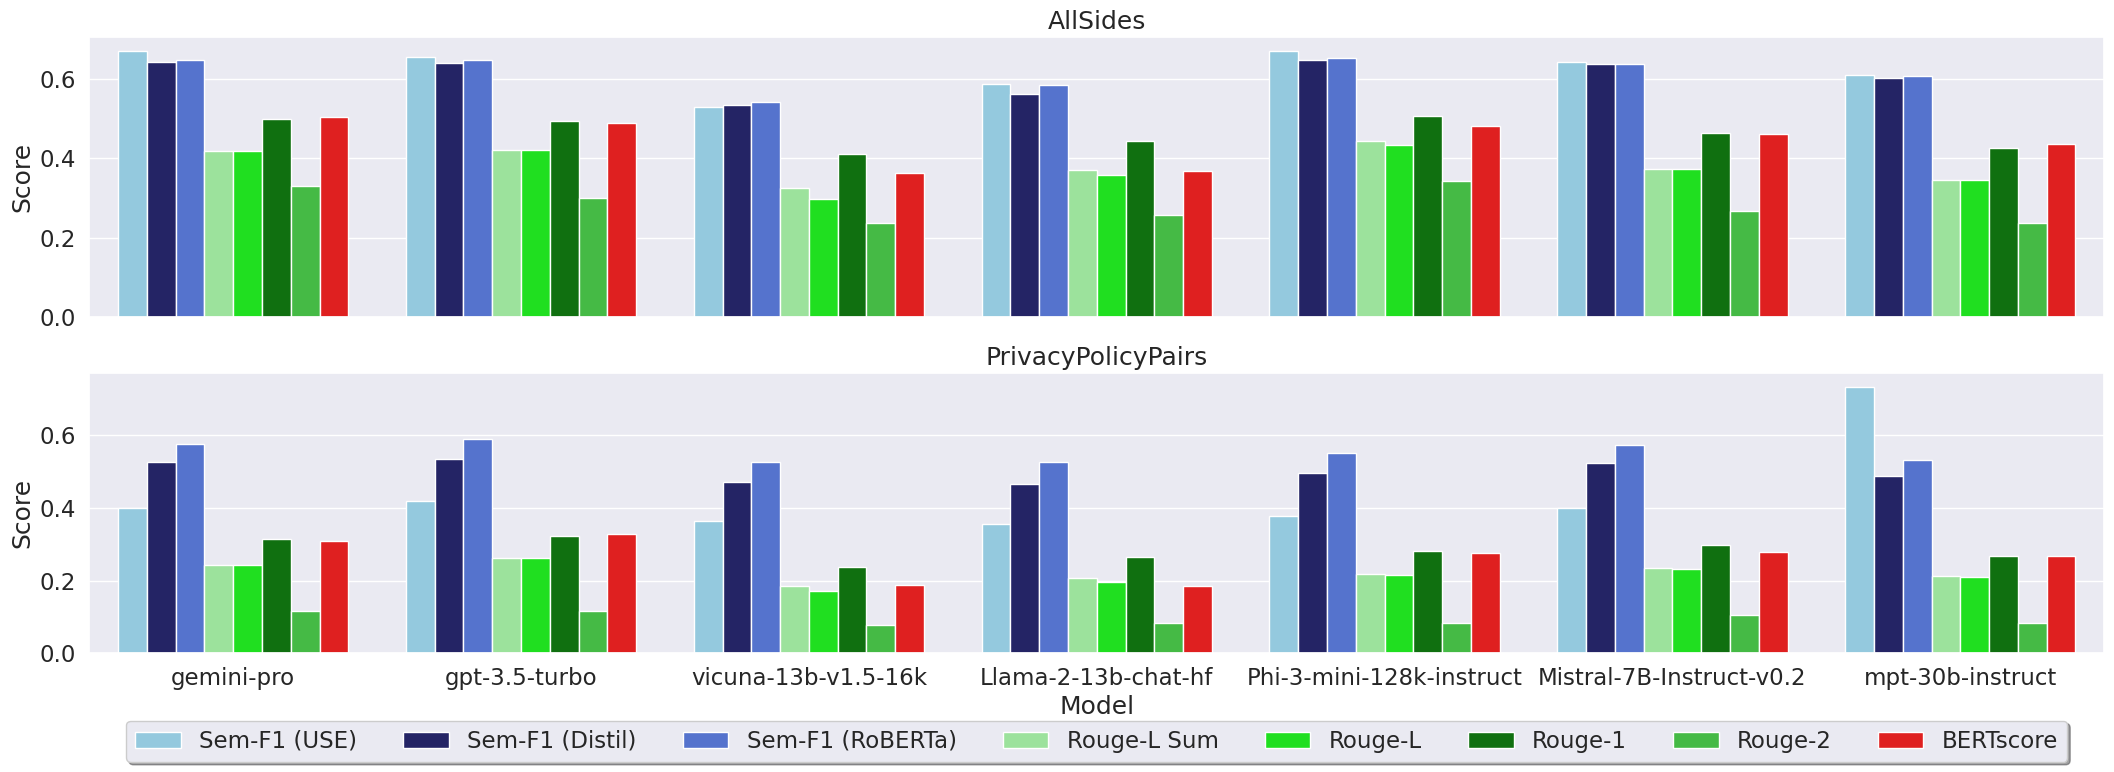

In [62]:
#################################################################################
# get max scores over prompt levels per model for the largest models per family #
#################################################################################
#plt.rcParams.update({'font.size': 56})
color_palette = {
    'BERTscore': 'red',
    'Rouge-1': 'green',
    'Rouge-2': 'limegreen',
    'Rouge-L': 'lime',
    'Rouge-L Sum': 'lightgreen',
    'Sem-F1 (Distil)': 'midnightblue',
    'Sem-F1 (RoBERTa)': 'royalblue',
    'Sem-F1 (USE)': 'skyblue',
}
col_map = {
    'bertscore': 'BERTscore',
    'rouge1': 'Rouge-1',
    'rouge2': 'Rouge-2',
    'rougeL': 'Rouge-L',
    'rougeLsum': 'Rouge-L Sum',
    'semf1-distil': 'Sem-F1 (Distil)',
    'semf1-rob': 'Sem-F1 (RoBERTa)',
    'semf1-use': 'Sem-F1 (USE)',
}
#results_ren = results.rename_columns(col_map)

name_map = {
    'all_sides': 'AllSides',
    'privacy_policy': 'PrivacyPolicyPairs',
}
models = set(ds['model'])

wh = 26.0, 8.0
sns.set_theme(
    rc={'figure.figsize': wh}, 
    font_scale=1.5
)
ds_names = ['all_sides', 'privacy_policy']
max_per_model_data = {name: [] for name in ds_names}
max_per_model_idxs = {name: [] for name in ds_names}
counts_per_tmplt = {
    'l0': 0, 'l1': 0, 'l2': 0,
    'l3': 0, 'l4': 0, 'icl': 0,
}

for name in ds_names:
    #data = results_ren.filter(lambda x: x['dataset'] == name).to_list()
    data = results.filter(lambda x: x['dataset'] == name).to_list()
    for model in sorted(models):
        model_data = list(filter(lambda x: x['model'] == model, data))
        model_ds = Dataset.from_list(model_data)

        #dict_head = {'Model': model, 'Dataset': name}
        dict_head = {'Model': model}
        maxes = {metric: max(model_ds[metric]) for metric in metrics}
        max_indices = {metric: np.argmax(model_ds[metric]) for metric in metrics}

        new_samples = [
            {'Model': model, 'Score': maxes[metric], 'Metric': col_map[metric]} 
            for metric in metrics
        ]
        max_per_model_data[name] += new_samples

        #max_per_model_data[name].append({**dict_head, **maxes})
        # update level counts
        max_per_model_idxs[name].append({**dict_head, **max_indices})

        # TODO put this back in to count prompts
        """
        for metric in metrics:
            counts_per_tmplt[max_per_model_idxs[name][-1][metric]] += 1
        """

# filter out smaller models
keep_models = [
    'gemini-pro',
    'gpt-3.5-turbo',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'lmsys/vicuna-13b-v1.5-16k',
    'mosaicml/mpt-30b-instruct',
    'meta-llama/Llama-2-13b-chat-hf',
    'microsoft/Phi-3-mini-128k-instruct',
]

for dsn, dsl in max_per_model_data.items():
    max_per_model_data[dsn] = list(filter(
        lambda x: x['Model'] in keep_models, 
        dsl
    ))

# truncate from model names
for dsn in max_per_model_data.keys():
    for item in max_per_model_data[dsn]:
        item['Model'] = item['Model'].split('/')[-1]

dataframes = {name: pd.DataFrame(max_per_model_data[name]) for name in ds_names}
"""
for key, val in dataframes.items():
    dataframes[key] = val.rename(columns=col_map)
print(dataframes['all_sides'])
"""

# plot data
fig, ax = plt.subplots(2, 1, sharex=True)
for i, (name, df) in enumerate(dataframes.items()):
    legend = True if i==1 else False
    for j, bar in enumerate(sns.barplot(x='Model',
                                        y='Score',
                                        hue='Metric',
                                        data=df,
                                        ax=ax[i],
                                        legend=legend,
                                        palette=color_palette).patches):
        #bar.set_hatch(hatch_patterns[j // 6])
        pass
    ax[i].set_title(name_map[name])
    ax[1].legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2), 
        fancybox=True, 
        shadow=True, 
        ncol=8
    )
    #ax[i].tick_params(axis='x', labelrotation=15)

Filter: 100%|██████████| 7072/7072 [00:00<00:00, 144174.23 examples/s]


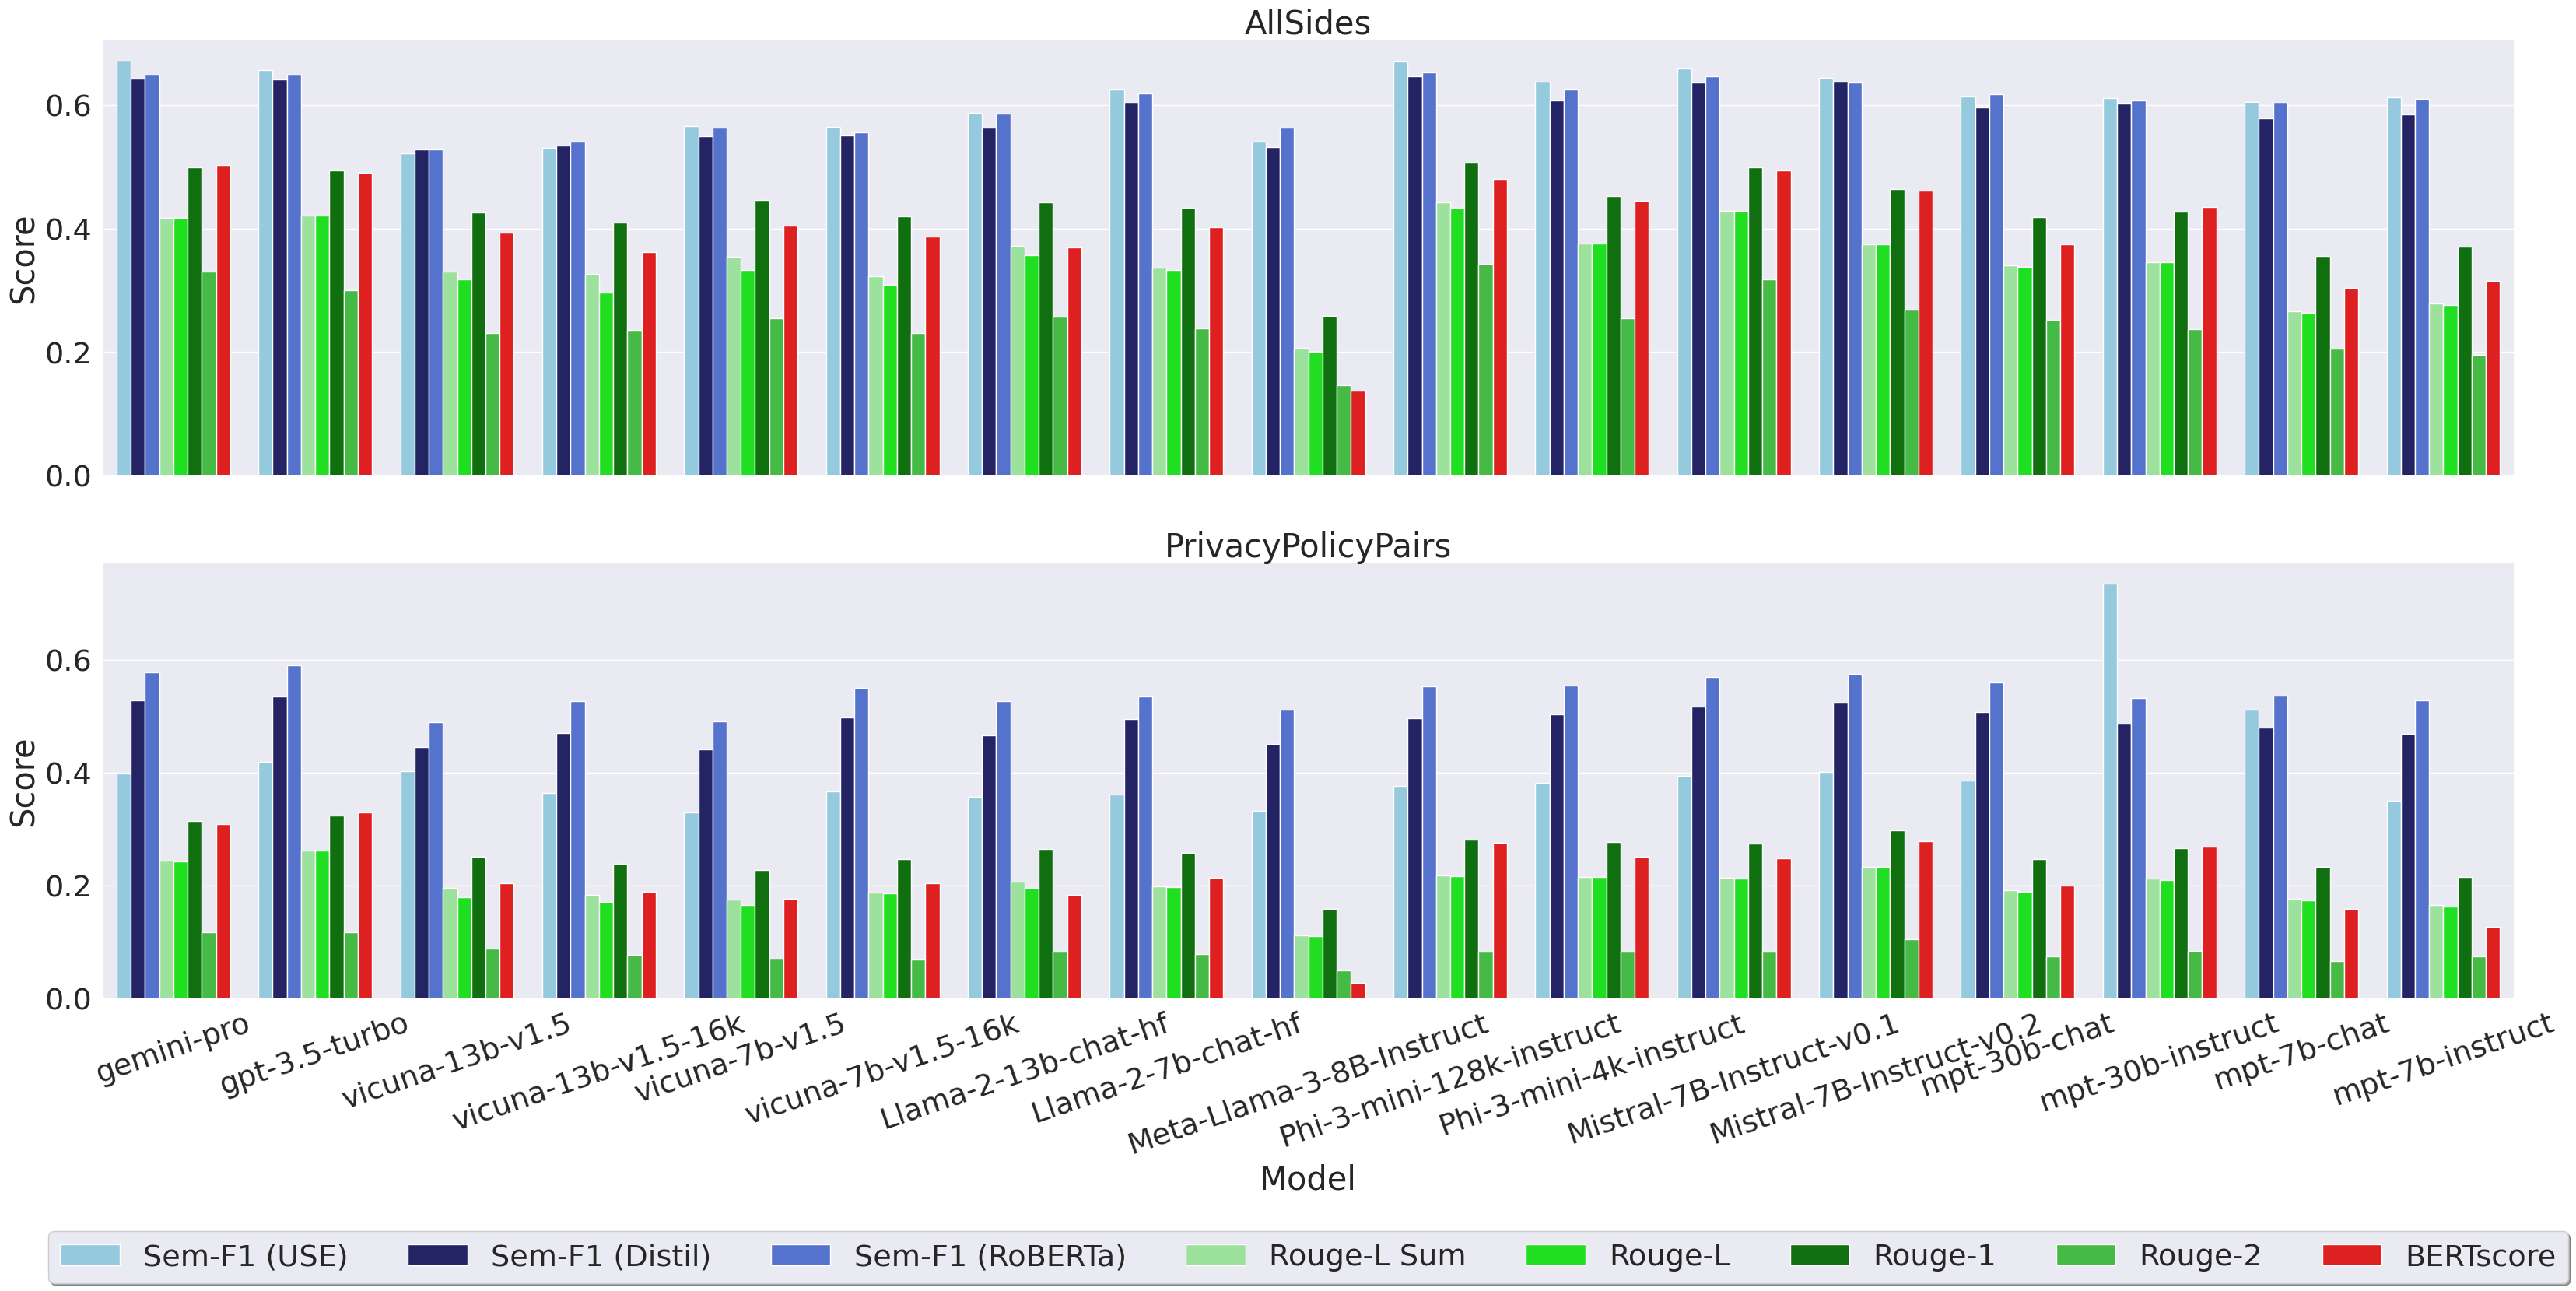

In [124]:

##################################################################
# get max scores over prompt levels per model for the all models #
##################################################################
#plt.rcParams.update({'font.size': 56})
color_palette = {
    'BERTscore': 'red',
    'Rouge-1': 'green',
    'Rouge-2': 'limegreen',
    'Rouge-L': 'lime',
    'Rouge-L Sum': 'lightgreen',
    'Sem-F1 (Distil)': 'midnightblue',
    'Sem-F1 (RoBERTa)': 'royalblue',
    'Sem-F1 (USE)': 'skyblue',
}
col_map = {
    'bertscore': 'BERTscore',
    'rouge1': 'Rouge-1',
    'rouge2': 'Rouge-2',
    'rougeL': 'Rouge-L',
    'rougeLsum': 'Rouge-L Sum',
    'semf1-distil': 'Sem-F1 (Distil)',
    'semf1-rob': 'Sem-F1 (RoBERTa)',
    'semf1-use': 'Sem-F1 (USE)',
}
#results_ren = results.rename_columns(col_map)

name_map = {
    'all_sides': 'AllSides',
    'privacy_policy': 'PrivacyPolicyPairs',
}
models = set(ds['model'])

wh = 40.0, 16.0
sns.set_theme(
    rc={'figure.figsize': wh}, 
    font_scale=2.5
)
ds_names = ['all_sides', 'privacy_policy']
max_per_model_data = {name: [] for name in ds_names}
max_per_model_idxs = {name: [] for name in ds_names}
counts_per_tmplt = {
    'l0': 0, 'l1': 0, 'l2': 0,
    'l3': 0, 'l4': 0, 'icl': 0,
}

for name in ds_names:
    data = results.filter(lambda x: x['dataset'] == name).to_list()
    for model in sorted(models):
        model_data = list(filter(lambda x: x['model'] == model, data))
        model_ds = Dataset.from_list(model_data)

        #dict_head = {'Model': model, 'Dataset': name}
        dict_head = {'Model': model}
        maxes = {}

        for metric in metrics:
            model_scores = np.array(model_ds[metric])
            model_scores[model_scores > 1] = 0
            maxes[metric] = np.max(model_scores)
        #maxes = {metric: max(model_ds[metric]) for metric in metrics}
        max_indices = {metric: np.argmax(model_ds[metric]) for metric in metrics}

        new_samples = [
            {'Model': model, 'Score': maxes[metric], 'Metric': col_map[metric]} 
            for metric in metrics
        ]
        max_per_model_data[name] += new_samples

        #max_per_model_data[name].append({**dict_head, **maxes})
        # update level counts
        max_per_model_idxs[name].append({**dict_head, **max_indices})

        # TODO put this back in to count prompts
        """
        for metric in metrics:
            counts_per_tmplt[max_per_model_idxs[name][-1][metric]] += 1
        """

# filter out smaller models
keep_models = [
    'gemini-pro',
    'gpt-3.5-turbo',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'lmsys/vicuna-13b-v1.5-16k',
    'mosaicml/mpt-30b-instruct',
    'meta-llama/Llama-2-13b-chat-hf',
    'microsoft/Phi-3-mini-128k-instruct',
]

"""
for dsn, dsl in max_per_model_data.items():
    max_per_model_data[dsn] = list(filter(
        lambda x: x['Model'] in keep_models, 
        dsl
    ))
"""

# truncate from model names
for dsn in max_per_model_data.keys():
    for item in max_per_model_data[dsn]:
        item['Model'] = item['Model'].split('/')[-1]

dataframes = {name: pd.DataFrame(max_per_model_data[name]) for name in ds_names}
"""
for key, val in dataframes.items():
    dataframes[key] = val.rename(columns=col_map)
print(dataframes['all_sides'])
"""

# plot data
fig, ax = plt.subplots(2, 1, sharex=True)
for i, (name, df) in enumerate(dataframes.items()):
    legend = True if i==1 else False
    for j, bar in enumerate(sns.barplot(x='Model',
                                        y='Score',
                                        hue='Metric',
                                        data=df,
                                        ax=ax[i],
                                        legend=legend,
                                        palette=color_palette).patches):
        #bar.set_hatch(hatch_patterns[j // 6])
        pass
    ax[i].set_title(name_map[name])
ax[1].legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.5), 
    fancybox=True, 
    shadow=True, 
    ncol=8
)
#ax[1].set_xticklabels(labels, rotation=15, ha='right')
ax[1].tick_params(axis='x', labelrotation=19)

In [35]:
print(set(results['template']))

{'l4', 'l1', 'l0', 'l3', 'l2', 'icl'}


In [119]:

##################################################################
# get max scores over prompt levels per model for the all models #
##################################################################
#plt.rcParams.update({'font.size': 56})

metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]

col_map = {
    'bertscore': 'BERTscore',
    'rouge1': 'Rouge-1',
    'rouge2': 'Rouge-2',
    'rougeL': 'Rouge-L',
    'rougeLsum': 'Rouge-L Sum',
    'semf1-distil': 'Sem-F1 (Distil)',
    'semf1-rob': 'Sem-F1 (RoBERTa)',
    'semf1-use': 'Sem-F1 (USE)',
}
#results_ren = results.rename_columns(col_map)

name_map = {
    'all_sides': 'AllSides',
    'privacy_policy': 'PrivacyPolicyPairs',
}
models = set(ds['model'])

wh = 40.0, 16.0
sns.set_theme(
    rc={'figure.figsize': wh}, 
    font_scale=2.5
)
ds_names = ['all_sides', 'privacy_policy']
max_per_model_data = {name: [] for name in ds_names}
max_per_model_idxs = {name: [] for name in ds_names}
counts_per_tmplt = {
    'l0': 0, 'l1': 0, 'l2': 0,
    'l3': 0, 'l4': 0, 'icl': 0,
}
counts_per_ds = {
    'privacy_policy': {'l0': 0, 'l1': 0, 'l2': 0,
                       'l3': 0, 'l4': 0, 'icl': 0},
    'all_sides': {'l0': 0, 'l1': 0, 'l2': 0,
                  'l3': 0, 'l4': 0, 'icl': 0}
}

counts_per_metric = {
    metric: {'l0': 0, 'l1': 0, 'l2': 0, 'l3': 0, 'l4': 0, 'icl': 0,} 
    for metric in col_map.keys()
}
model_counts = {
    model: {'l0': 0, 'l1': 0, 'l2': 0, 'l3': 0, 'l4': 0, 'icl': 0,}
    for model in models
}
    

score_table = {name: [] for name in ds_names}
for name in ds_names:
    data = results.filter(lambda x: x['dataset'] == name).to_list()
    for model in sorted(models):
        model_data = list(filter(lambda x: x['model'] == model, data))
        model_ds = Dataset.from_list(model_data)
        sample = {'model': model}

        #dict_head = {'Model': model, 'Dataset': name}
        dict_head = {'Model': model}
        maxes = {}

        for metric in metrics:
            model_scores = np.array(model_ds[metric])
            model_scores[model_scores > 1] = 0
            idx = int(np.argmax(model_scores))
            sample[metric] = (
                f'{model_scores[idx]:.03f} ({model_ds[idx]["template"]})'
            )
            tmplt = model_ds[idx]['template']
            counts_per_tmplt[tmplt] += 1
            counts_per_ds[name][tmplt] += 1
            #sample[metric] = np.max(model_scores)
            counts_per_metric[metric][tmplt] += 1
            model_counts[model][tmplt] += 2

        score_table[name].append(sample)


# truncate from model names
for dsn in score_table.keys():
    for item in score_table[dsn]:
        item['model'] = item['model'].split('/')[-1]

dataframes = {name: pd.DataFrame(score_table[name]) for name in ds_names}

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)
for name in ds_names:
    print(f'\n{name}:')
    print(dataframes[name])

model_counts = {key: model_counts[key] for key in sorted(model_counts)}
print(json.dumps(counts_per_ds, indent=4))
print(json.dumps(counts_per_metric, indent=4))
print(json.dumps(model_counts, indent=4))

Filter:   0%|          | 0/7072 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7072 [00:00<?, ? examples/s]


all_sides:
                       model   semf1-use semf1-distil   semf1-rob   rougeLsum      rougeL      rouge1      rouge2   bertscore
0                 gemini-pro  0.671 (l1)   0.643 (l1)  0.648 (l1)  0.418 (l1)  0.418 (l1)  0.499 (l1)  0.331 (l1)  0.503 (l1)
1              gpt-3.5-turbo  0.656 (l1)   0.641 (l4)  0.648 (l1)  0.421 (l1)  0.421 (l1)  0.494 (l1)  0.300 (l1)  0.490 (l1)
2            vicuna-13b-v1.5  0.521 (l2)   0.528 (l2)  0.528 (l3)  0.330 (l3)  0.317 (l3)  0.426 (l2)  0.231 (l2)  0.393 (l2)
3        vicuna-13b-v1.5-16k  0.530 (l3)   0.535 (l3)  0.540 (l3)  0.326 (l2)  0.296 (l4)  0.410 (l2)  0.236 (l1)  0.362 (l2)
4             vicuna-7b-v1.5  0.566 (l4)   0.549 (l4)  0.563 (l4)  0.355 (l2)  0.333 (l2)  0.446 (l2)  0.255 (l2)  0.405 (l2)
5         vicuna-7b-v1.5-16k  0.564 (l3)   0.550 (l3)  0.555 (l3)  0.323 (l2)  0.309 (l2)  0.419 (l2)  0.231 (l2)  0.387 (l2)
6        Llama-2-13b-chat-hf  0.586 (l2)   0.563 (l2)  0.586 (l3)  0.372 (l1)  0.357 (l1)  0.442 (l1)  0.2

In [115]:
templates = sorted(set(ds['template']))
ds_names = ['all_sides', 'privacy_policy']
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
metric_prefs = []

for name, tmplt in product(ds_names, templates):
    filtered_results = results.filter(
        lambda x: x['dataset'] == name and x['template'] == tmplt
    )
    sample = {'dataset': name, 'template': tmplt}

    for metric in metrics:
        #metric_prefs[name][tmplt][metric] = round(np.max(filtered_results[metric]), 3)
        met_sc = np.array(filtered_results[metric], dtype=float)
        met_sc[met_sc > 1] = 0
        sample[metric] = round(np.max(met_sc), 3)
    metric_prefs.append(sample)

print(json.dumps(metric_prefs, indent=4))

Filter: 100%|██████████| 7072/7072 [00:00<00:00, 150762.75 examples/s]


[
    {
        "dataset": "all_sides",
        "template": "icl",
        "semf1-use": 0.651,
        "semf1-distil": 0.621,
        "semf1-rob": 0.639,
        "rougeLsum": 0.367,
        "rougeL": 0.367,
        "rouge1": 0.46,
        "rouge2": 0.267,
        "bertscore": 0.453
    },
    {
        "dataset": "all_sides",
        "template": "l0",
        "semf1-use": 0.614,
        "semf1-distil": 0.6,
        "semf1-rob": 0.618,
        "rougeLsum": 0.315,
        "rougeL": 0.291,
        "rouge1": 0.399,
        "rouge2": 0.209,
        "bertscore": 0.391
    },
    {
        "dataset": "all_sides",
        "template": "l1",
        "semf1-use": 0.671,
        "semf1-distil": 0.646,
        "semf1-rob": 0.652,
        "rougeLsum": 0.442,
        "rougeL": 0.433,
        "rouge1": 0.507,
        "rouge2": 0.342,
        "bertscore": 0.503
    },
    {
        "dataset": "all_sides",
        "template": "l2",
        "semf1-use": 0.653,
        "semf1-distil": 0.631,
        "semf

# Calculate Sem-nCG For All Data

In [ ]:
ds_names = ['all_sides', 'privacy_policy']
doc_cols = {
    'all_sides': ['Left', 'Right'],
    'privacy_policy': ['Company_1', 'Company_2'],
}
metric = evaluate.load("nbansal/semncg")

preds = ds['response']

# identify datasets
ds_flag = np.array([1 if x=='all_sides' else 0 for x in ds['dataset']])
sample_ids = {
    'all_sides': np.where(ds_flag == 1)[0],
    'privacy_policy': np.where((ds_flag == 0)[0]),
}
print(sample_ids['all_sides'])

# combine source documents and build reference lists
docs = []
for sample in tqdm(ds, desc='building docs'):
    name = sample['dataset']
    sid = sample['id']
    docs.append(' '.join([ref_data[name][sid][col] for col in doc_cols[name]]))

semncg = {name: dict() for name in ds_names}
index_dict = dict()
for ds_name, sids in tqdm(sample_ids.items(), position=0, leave=False):
    ds_data = ds.select(sids)

    indices = [
        i for i, sample in enumerate(tqdm(ds_data, leave=True)) 
        if sample['response'] != '' and sample['response'] is not None
    ]
    indices = [
        i for i in tqdm(indices, leave=True)
        if ds_data[i]['response'].translate(str.maketrans('', '', string.punctuation)).strip() != ''
    ]
    index_dict[ds_name] = indices

    ds_docs = [docs[i] for i in indices]
    preds = ds_data.select(indices)['response']
    for ref_col in tqdm(ref_cols[ds_name], position=1, leave=False):

        refs = [ref_data[ds_name][sid][ref_col] for sid in ds_data.select(indices)['id']]

        mean_score, scores = metric.compute(
            predictions=preds,
            references=refs,
            documents=ds_docs,
            verbose=False,
        )
            
        semncg[ds_name][ref_col] = scores

/tmp/ipykernel_1858120/2011927876.py:14: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  'privacy_policy': np.where((ds_flag == 0)[0]),


[     0      1      2 ... 961504 961505 961506]


  0%|          | 0/2 [00:00<?, ?it/s]




































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import pickle
with open('data.pkl', 'w') as f:
    f.write(pickle.dumps(semncg))

In [24]:
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2'],
    num_rows: 961792
})


In [21]:
ref_data

{'all_sides': Dataset({
     features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
     num_rows: 137
 }),
 'privacy_policy': Dataset({
     features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
     num_rows: 135
 })}

In [14]:
print(ref_cols)

{'all_sides': ['Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'], 'privacy_policy': ['Annotator1', 'Annotator2', 'Annotator3']}


In [52]:
print(ref_data)

{'all_sides': Dataset({
    features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
    num_rows: 137
}), 'privacy_policy': Dataset({
    features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
    num_rows: 135
})}


In [11]:
human_scores

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 630
})

Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

Filter:   0%|          | 0/628 [00:00<?, ? examples/s]

Filter:   0%|          | 0/628 [00:00<?, ? examples/s]

Filter:   0%|          | 0/628 [00:00<?, ? examples/s]

Filter:   0%|          | 0/628 [00:00<?, ? examples/s]

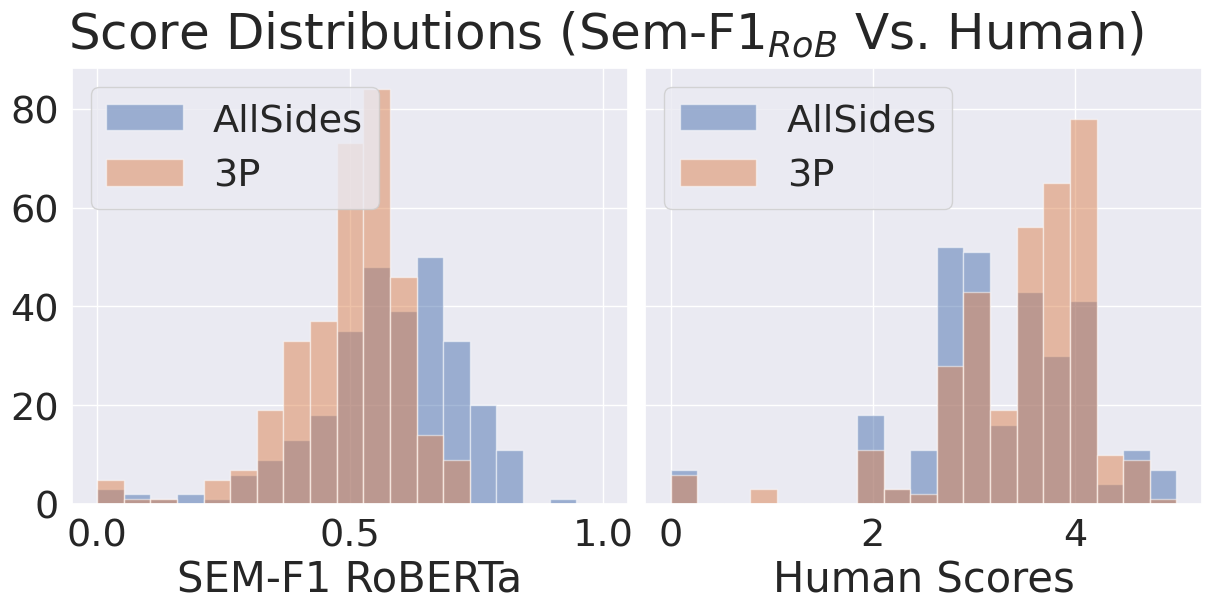

In [76]:
#data = ds
data = human_scores
cols = ['semf1-rob', 'annotator_agreement']
label_map = {
    'semf1-rob': 'SEM-F1 RoBERTa',
    #'annotator_agreement': r'Ann$_{comb}$',
    'annotator_agreement': 'Human Scores',
}
title_map = {
    'all_sides': 'AllSides',
    'privacy_policy': '3P',
}
bins = {
    'semf1-rob': np.linspace(0, 1, 20),
    'annotator_agreement': np.linspace(0, 5, 20),
}
filtered_data = data.filter(lambda x: x[cols[0]] is not None and x[cols[1]] is not None)
#col = 'annotator_agreement'

ds_names = ['all_sides', 'privacy_policy']
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 6),
    sharey=True,
    layout='constrained',
)
for i, col in enumerate(cols):
    for name in ds_names:
        ax[i].hist(
            filtered_data.filter(lambda x: x['dataset'] == name)[col],
            bins=bins[col],
            alpha=0.5,
            label=title_map[name],
        )
        ax[i].legend(loc='upper left')
        #ax[i].set_title(label_map[col])
        ax[i].set_xlabel(label_map[col])
fig.suptitle(r'Score Distributions (Sem-F1$_{RoB}$ Vs. Human)')
plt.savefig('/data/john/score_distribution.png')

In [46]:
ref_data['all_sides']
print(human_scores['annotator_agreement'])

[3.8, 1.0, 3.0, 0.0, 4.0, 4.0, 3.5, 3.8, 4.5, 4.5, 4.5, 3.5, 3.8, 4.0, 4.0, 3.7, 3.7, 4.0, 4.0, 3.5, 0.0, 2.8, 2.8, 2.8, 3.5, 3.0, 3.2, 4.0, 3.4, 4.0, 3.7, 3.3, 0.0, 3.9, 4.2, 4.3, 4.0, 4.3, 2.8, 4.0, 4.2, 4.5, 2.2, 3.5, 4.0, 4.0, 2.8, 4.0, 3.0, 3.2, 4.2, 4.3, 3.0, 2.0, 4.0, 2.0, 3.5, 3.0, 3.0, 3.5, 2.8, 3.0, 3.3, 3.5, 3.4, 2.0, 4.0, 3.5, 2.8, 3.6, 3.6, 3.5, 3.7, 3.0, 3.8, 3.0, 3.0, 2.8, 2.8, 3.0, 4.0, 3.5, 3.0, 3.8, 3.5, 3.0, 3.6, 3.7, 4.0, 3.0, 3.5, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.5, 3.7, 2.8, 2.0, 3.8, 3.5, 2.5, 4.0, 2.8, 3.5, 3.5, 3.8, 3.8, 2.8, 3.5, 3.0, 3.0, 3.0, 3.4, 3.0, 3.7, 3.5, 3.0, 3.0, 2.8, 2.8, 2.8, 2.8, 3.0, 2.8, 2.0, 3.5, 3.5, 2.8, 2.8, 3.4, 3.5, 4.0, 3.8, 3.3, 2.8, 2.8, 3.5, 3.4, 3.5, 2.8, 2.8, 3.0, 3.5, 3.4, 2.4, 3.0, 3.2, 3.0, 2.8, 2.8, 2.8, 3.0, 2.5, 2.8, 3.0, 3.2, 3.0, 3.0, 2.2, 2.2, 3.0, 2.0, 2.8, 2.5, 3.0, 3.0, 2.8, 2.0, 3.0, 2.8, 2.0, 2.0, 2.8, 4.0, 3.5, 3.8, 3.0, 2.8, 3.7, 3.0, 3.5, 3.8, 2.8, 3.4, 2.8, 3.5, 2.8, 2.5, 2.8, 3.0, 3.5, 3.0, 3.0, 2.8, 2.8, 2.8, 2.8,

In [8]:
# connect to db
cur = con.cursor()

keys = [
    'id', 'template', 'dataset', 'system', 'prompt', 'response',
    'el_index', 'semf1_use', 'semf1_distil', 'semf1_rob', 'bertscore',
    'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum',
    'rougeL', 'rouge1', 'rouge2',
]

metrics = [
    'semf1_use', 'semf1_distil', 'semf1_rob', 'bertscore',
    'rougeLsum' ,'rougeL', 'rouge1', 'rouge2',
]
ds_names = ['all_sides', 'privacy_policy']

stats = []
models = set([
    model[0] for model in 
    cur.execute('SELECT DISTINCT model from scores')
])
for model in tqdm(models, position=0):
    for ds_name in tqdm(ds_names, position=1):
        for metric in tqdm(metrics, position=2):
            sample = {
                'model': model,
                'metric': metric,
                'dataset': ds_name,
            }
            print(models)
            scores = np.array([
                score[0] for score in 
                cur.execute(f"SELECT {metric} from scores")
            ])
            el = {'metric'}
            stats.append({'mo
        })
cur.close()

{'meta-llama/Llama-2-7b-chat-hf', 'mosaicml/mpt-30b-chat', 'mosaicml/mpt-7b-chat', 'lmsys/vicuna-13b-v1.5-16k', 'mosaicml/mpt-7b-instruct', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5-16k', 'microsoft/Phi-3-mini-4k-instruct', 'microsoft/Phi-3-mini-128k-instruct', 'gemini-pro', 'mosaicml/mpt-30b-instruct', 'gpt-3.5-turbo', 'lmsys/vicuna-7b-v1.5', 'mistralai/Mistral-7B-Instruct-v0.2', 'lmsys/vicuna-13b-v1.5', 'meta-llama/Llama-2-13b-chat-hf'}
0.4612424532264451


# Compute Average Scores Per TELeR Level

In [35]:

metrics = [
    'semf1_use', 'semf1_distil', 'semf1_rob', 'bertscore',
    'rougeLsum' ,'rougeL', 'rouge1', 'rouge2',
]
ds_names = ['all_sides', 'privacy_policy']
templates = ['l0', 'l1', 'l2', 'l3', 'l4', 'icl']
avgs = []
for ds_name, template in tqdm(list(product(ds_names, templates))):
    sample = {'dataset': ds_name, 'template': template}
    for metric in metrics:
        cur = con.cursor()

        scores = np.array([
            el[0] for el in 
            cur.execute(
                f"SELECT {metric} FROM scores "
                f"WHERE dataset='{ds_name}' and template='{template}'"
            )
        ])
        scores[scores > 1] = 1
        sample[metric] = np.mean(scores)
        #el[metric] = 

    avgs.append(sample)
    cur.close()

df = pd.DataFrame(
    avgs,
    columns=['dataset', 'template']+metrics,
)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)
df = df.reindex(columns=[
    'dataset', 'template', 'bertscore', 'rouge1', 'rouge2', 'rougeLsum',
    'rougeL', 'semf1_distil', 'semf1_rob', 'semf1_use'
])
print(df)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [01:13<00:00,  6.17s/it]

           dataset template  bertscore  rouge1  rouge2  rougeLsum  rougeL  semf1_distil  semf1_rob  semf1_use
0        all_sides       l0      0.173   0.279   0.135      0.212   0.192         0.476      0.494      0.482
1        all_sides       l1      0.281   0.356   0.188      0.276   0.258         0.524      0.538      0.535
2        all_sides       l2      0.240   0.339   0.170      0.257   0.243         0.516      0.535      0.532
3        all_sides       l3      0.297   0.358   0.175      0.273   0.263         0.499      0.526      0.526
4        all_sides       l4      0.244   0.335   0.162      0.259   0.250         0.457      0.481      0.476
5        all_sides      icl      0.179   0.286   0.129      0.214   0.202         0.423      0.450      0.447
6   privacy_policy       l0     -0.004   0.134   0.042      0.109   0.096         0.411      0.468      0.304
7   privacy_policy       l1      0.116   0.199   0.062      0.157   0.147         0.440      0.481      0.317
8   privac

In [57]:
ann_keys = [
    'Column1', 'doc1', 'doc2', 'response', 'id', 'template', 
    'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 
    'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 
    'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 
    'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'
]
ds_names = ['all_sides', 'privacy_policy']
elids = dict()
cur = con.cursor()
for ds_name in ds_names:
    ids = list(set(
        el[0] for el in
        cur.execute(
            f"SELECT id from annotations where dataset='{ds_name}'"
        )
    ))
    elids[ds_name] = ids

cur.close()
stats = []
print(elids)
for ds_name, idlist in elids.items():
    for elid in idlist:
        sample = {'dataset': ds_name, 'id': elid}
        cur = con.cursor()
        scores = np.array([
            el[0] if el[0] else 0 for el in
            cur.execute(
            f'SELECT annotator_agreement from annotations where dataset="{ds_name}" and id={elid}')
        ])
        sample['var'] = np.var(scores)
        sample['mean'] = np.mean(scores)
        sample['std'] = np.std(scores)
        stats.append(sample)
        cur.close()

print(pd.DataFrame(stats))

{'all_sides': [97, 98, 133, 44, 51, 87, 90], 'privacy_policy': [134, 103, 113, 125, 22, 122, 91, 29]}
           dataset   id    var   mean    std
0        all_sides   97  0.279  3.367  0.529
1        all_sides   98  0.947  3.098  0.973
2        all_sides  133  0.601  3.762  0.775
3        all_sides   44  0.268  3.276  0.517
4        all_sides   51  0.200  2.979  0.447
5        all_sides   87  0.414  2.890  0.644
6        all_sides   90  1.621  3.298  1.273
7   privacy_policy  134  0.682  3.579  0.826
8   privacy_policy  103  0.761  3.569  0.872
9   privacy_policy  113  0.399  3.533  0.632
10  privacy_policy  125  0.480  3.600  0.692
11  privacy_policy   22  1.300  3.417  1.140
12  privacy_policy  122  0.774  3.364  0.880
13  privacy_policy   91  0.279  3.143  0.528
14  privacy_policy   29  0.340  3.276  0.583


In [85]:
hs = human_scores.filter(lambda x: x['model'] != 'meta-llama/Meta-Llama-3-8B-Instruct')

Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

In [104]:

templates = {'l0', 'l1', 'l2', 'l3', 'l4', 'icl'}
lengths = {
    'privacy_policy': {'l0': 0, 'l1': 0, 'l2': 0,
                       'l3': 0, 'l4': 0, 'icl': 0},
    'all_sides': {'l0': 0, 'l1': 0, 'l2': 0,
                  'l3': 0, 'l4': 0, 'icl': 0}
}
ds_names = ['all_sides', 'privacy_policy']
#lengths = dict()
for ds_name in ds_names:
    for key in templates:
        cur = con.cursor()
        l = np.array([
            len(el[0]) if el[0] else 0 for el in 
            cur.execute(
                f"SELECT response from scores where template='{key}' and dataset='{ds_name}'"
            )
        ])
        #lengths[key] = np.mean(l)
        lengths[ds_name][key] = np.mean(l)
        cur.close()

for ds_name in ds_names:
    for template, vals in sorted(lengths[ds_name].items()):
        print(f'{ds_name}-{template}: {np.mean(vals):.02f}')

cur = con.cursor()

cur.close()

all_sides-icl: 936.09
all_sides-l0: 1337.85
all_sides-l1: 840.66
all_sides-l2: 841.37
all_sides-l3: 606.72
all_sides-l4: 532.23
privacy_policy-icl: 973.14
privacy_policy-l0: 1848.90
privacy_policy-l1: 903.32
privacy_policy-l2: 967.42
privacy_policy-l3: 590.84
privacy_policy-l4: 505.41


In [100]:
cur = con.cursor()

templates = ['icl', 'l0', 'l1', 'l2', 'l3', 'l4']
tables = [
    el[0] for el in 
    cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
]
print(tables)
models = [
    el[0] for el in
    cur.execute('SELECT DISTINCT model from average_performance')
]
print(models)
metric = 'semf1_roberta'
for model in models:
    entries = cur.execute(f"select (template, {metric}) from average_performance").fetchall()
    print(len(entries)
    counts = 
    for template in templates:

cur.close()

['scores', 'annotations', 'average_performance']
['gemini-pro', 'gpt-3.5-turbo', 'lmsys/vicuna-13b-v1.5', 'lmsys/vicuna-13b-v1.5-16k', 'lmsys/vicuna-7b-v1.5', 'lmsys/vicuna-7b-v1.5-16k', 'meta-llama/Llama-2-13b-chat-hf', 'meta-llama/Llama-2-7b-chat-hf', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3-mini-4k-instruct', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.2', 'mosaicml/mpt-30b-chat', 'mosaicml/mpt-30b-instruct', 'mosaicml/mpt-7b-chat', 'mosaicml/mpt-7b-instruct']


In [111]:
templates = ['icl', 'l0', 'l1', 'l2', 'l3', 'l4']

cur = con.cursor()
for template in templates:
    scores = np.array([
        el[0] if el[0] else 0 for el in
        #cur.execute(f"select annotator_agreement from annotations where template='{template}' and model!='meta-llama/Meta-Llama-3-8B-Instruct'")
        cur.execute(f"select annotator_agreement from annotations where template='{template}'")
    ])
    print(f'{template}: {np.mean(scores)}')
cur.close()

cur = con.cursor()
models = [
    el[0] for el in 
    cur.execute('select distinct model from annotations')
]
print(models)
cur.close()

icl: 3.081904761904762
l0: 3.566666666666666
l1: 3.38
l2: 3.421904761904762
l3: 3.3180952380952378
l4: 3.291428571428572
['mistralai/Mistral-7B-Instruct-v0.2', 'gemini-pro', 'gpt-3.5-turbo', 'mosaicml/mpt-30b-chat', 'meta-llama/Meta-Llama-3-8B-Instruct', 'microsoft/Phi-3-mini-128k-instruct', 'lmsys/vicuna-13b-v1.5-16k']
